# Evalute Train/Test splits

This notebook evaluates the train/test splits we're using to establish a baseline.

We'd like the train set to have the extreme values, and the test set to have the more common values.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import dotenv_values

env = dotenv_values()
comp_data_loc = env.get("COMPOSITION_DATA_PATH")
dataset_loc = env.get("DATA_PATH")

if not comp_data_loc:
    print("Please set COMPOSITION_DATA_PATH in .env file")
    exit(1)

if not dataset_loc:
    print("Please set DATA_PATH in .env file")
    exit(1)

In [3]:
from lib.data_handling import CompositionData


cd = CompositionData(str(comp_data_loc))

In [4]:
from train_test_split import get_all_samples

samples = get_all_samples(cd, str(dataset_loc))

In [5]:
from train_test_split import filter_samples


filtered_samples = filter_samples(samples, [])

Fold 1
Train indices: [142 397 227 337   1 369  21 171 386 373 102 166 187  35   6  84 303 286
 261 112 266 133 268  60 174 163  28 327  59 137 175  48 183 348  56  98
  51  33  96 259  12  68 165  99 179  88 246 251 106 209 254 372 330 306
 160 226 114 223 394 245  77 107  76  34 207 139 122 239 210  31 283 358
 374 317  81  55 326  67 300 277 296 390 146 159 100 104 371 385 224 342
 233 252 393  16 320 375 349  32 152 150 301 334 341  57 120  86  75 378
  14 145 144   0 219 304 360 131 214 211  26 379 366   8  74 153 370 312
 352 380 181 265 377  97  38 135 118 293 328  66  69 339 387 231 156 388
 262 121 333 367  49 125 292 149  93 185  73   2 353 280 365 343  25 309
  87 216 177 335 116 401 359 321 148 242 329  10  50 117 110  46 178 258
  29 232 136 240 318 176  40  15 399  20 395 376  58  22 195  78 355 103
 190 119 274 302  13 101 263 289 212 331 208 205 264 128  62 361 138 127
 357 222  72 391 290 236 189 368 392  18 206 157 403 167 113  89 346 278
 356 363 313 308  43 294 197 

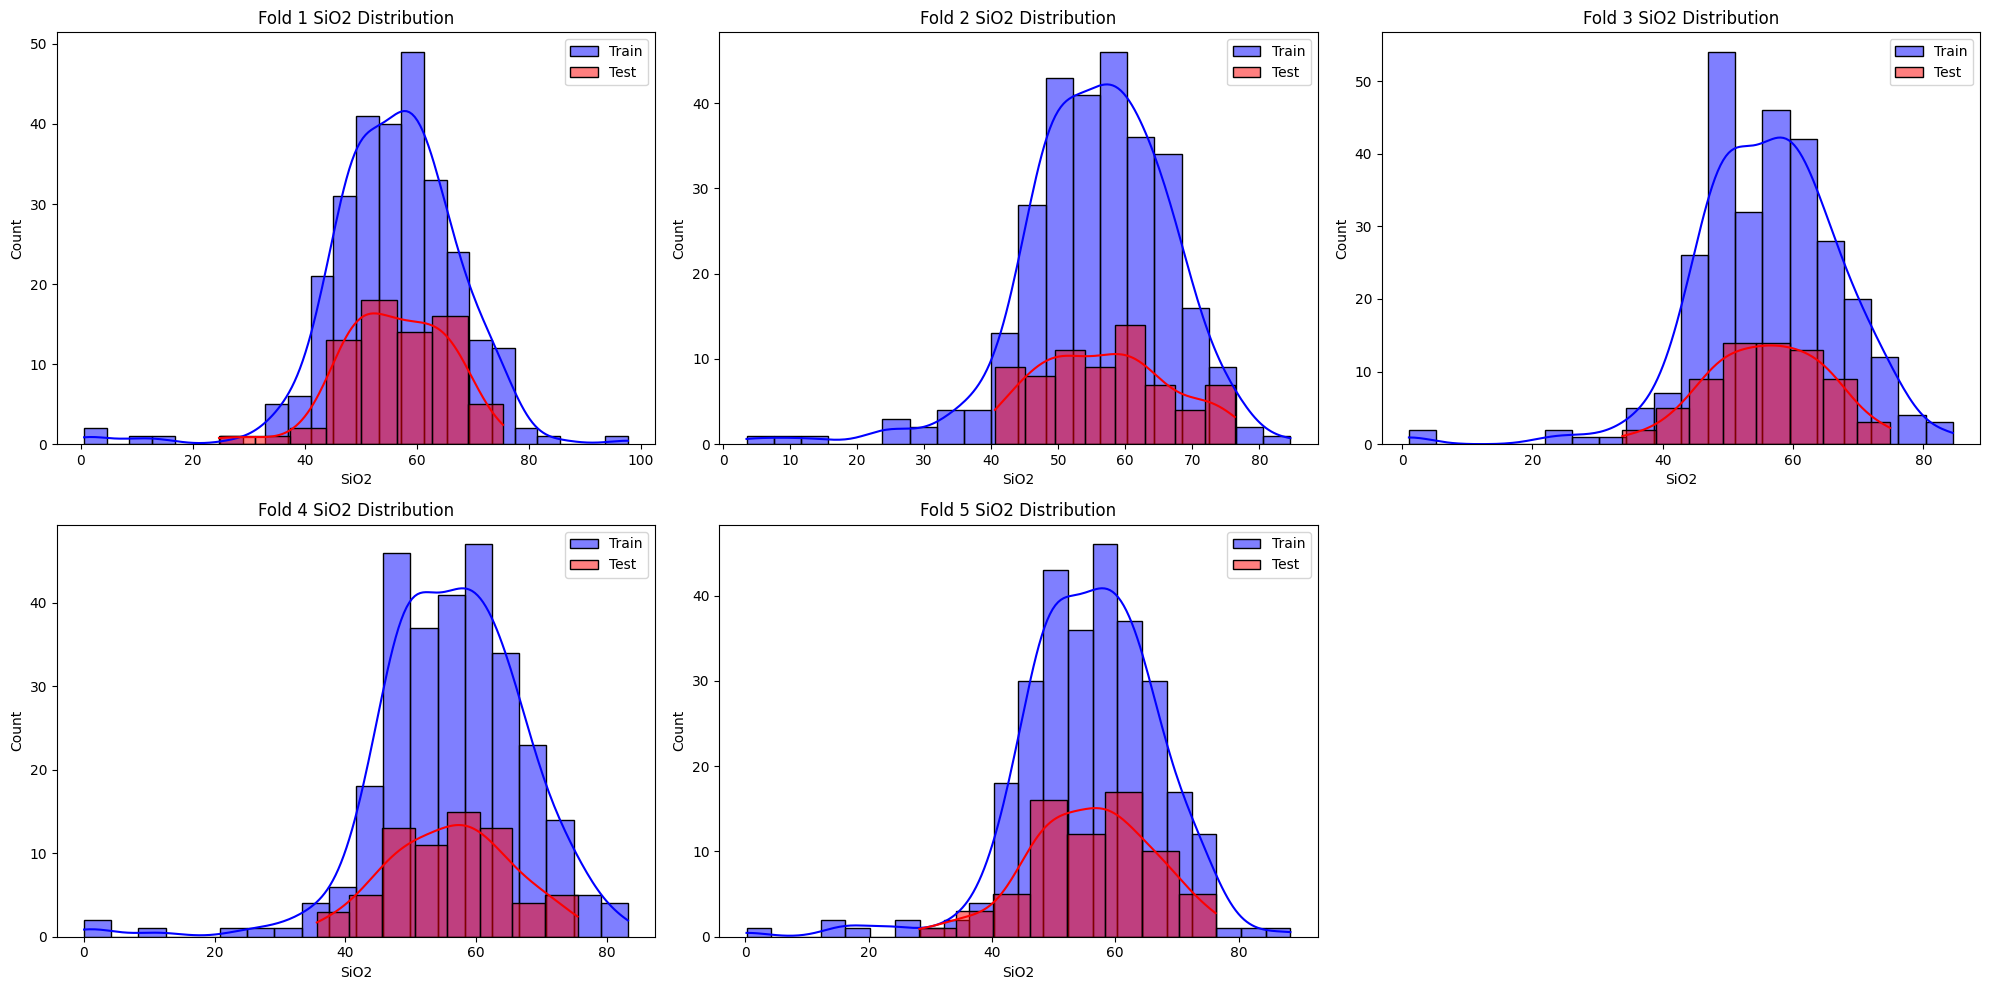

In [27]:
# Add the necessary imports
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

oxide = 'SiO2'

# ignore futurewarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Assuming df is already created and contains the composition data
# Focus on a single oxide, SiO2
df[f'{oxide}_bin'] = pd.qcut(df[oxide], q=4, labels=False)

# Identify extremes
percentage = 0.05
extreme_indices = df[(df[oxide] > df[oxide].quantile(1-percentage)) | (df[oxide] < df[oxide].quantile(percentage))].index
non_extreme_df = df.drop(extreme_indices)

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Generate the folds
for i, (train_index, test_index) in enumerate(kf.split(non_extreme_df, non_extreme_df[f'{oxide}_bin'])):
    # Adding extremes to each training set
    extreme_part = np.array_split(extreme_indices, 5)
    train_index = np.concatenate([non_extreme_df.index[train_index], extreme_part[i]])

    train, test = df.loc[train_index], df.loc[non_extreme_df.index[test_index]]
    print(f"Fold {i+1}")
    print("Train indices:", train_index, "Test indices:", non_extreme_df.index[test_index])
    print("Train set size:", len(train), "Test set size:", len(test))
    print("Train SiO2 distribution:\n", train[f'{oxide}_bin'].value_counts(normalize=True))
    print("Test SiO2 distribution:\n", test[f'{oxide}_bin'].value_counts(normalize=True))
    print("\n")

# Analysis of the results
# Plotting the distribution of the SiO2 variable in each fold
plt.figure(figsize=(20, 10))

for i, (train_index, test_index) in enumerate(kf.split(non_extreme_df, non_extreme_df[f'{oxide}_bin'])):
    extreme_part = np.array_split(extreme_indices, 5)
    train_index = np.concatenate([non_extreme_df.index[train_index], extreme_part[i]])
    train, test = df.loc[train_index], df.loc[non_extreme_df.index[test_index]]
    
    plt.subplot(2, 3, i+1)
    sns.histplot(train[oxide], kde=True, color='blue', label='Train')
    sns.histplot(test[oxide], kde=True, color='red', label='Test')
    plt.title(f'Fold {i+1} SiO2 Distribution')
    plt.legend()

plt.tight_layout()
plt.show()